In [1]:
!pip install cbbpy
!pip install geopy
!pip install mlxtend

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 34.3 MB/s eta 0:00:00


In [2]:
import cbbpy.mens_scraper as cbb
import numpy as np
import pandas as pd
import xgboost as xgb
from geopy import Nominatim
from geopy import distance as geodist
g = Nominatim(user_agent='cbb-distance')

In [3]:
# Data has been downloaded to CSV files using mens_scrapper.get_games_conference()
# for the 2024 season so that reruns of this notebook are quicker. However the
# CSV files need to be uploaded each time.
conference_file_prefixes = [
    'acc',
    'americaeast',
    'asun',
    'atlantic10',
    'big10',
    'big12',
    'bigeast',
    'bigsky',
    'bigsouth',
    'bigwest',
    'caa',
    'confusa',
    'horizon',
    'ivy',
    'maac',
    'meac',
    'midamerican',
    'midcontinent',
    'missourivalley',
    'mtnwest',
    'northeast',
    'ohiovalley',
    'pac12',
    'patriot',
    'southeastern',
    'southern',
    'southland',
    'swac',
    'sunbelt',
    'wac',
    'wcc',
]

In [4]:
# Data cleaning steps added here.
def clean_info_data(df: pd.DataFrame) -> pd.DataFrame:
  # Since we run eval() on the {home|away}_record columns, and eval()
  # fails on empty strings, just remove any rows with empty values.
  df = df[df['home_record'] != '']
  df = df[df['away_record'] != '']
  df = df.dropna(subset=['home_record', 'away_record'])
  return df

In [5]:
# Data transform steps added here.
def xfm_info_data(df: pd.DataFrame) -> pd.DataFrame:
  # Apply eval() to each {home|away}_record. Since each record value is stored
  # in the format like, "3-5", eval() will treat it as an arithmetic problem
  # and return the plus/minus integer value, e.g., -2.
  df['home_record_plusminus'] = df['home_record'].apply(eval)
  df['away_record_plusminus'] = df['away_record'].apply(eval)
  # Convert game day to datetime so we can sort it to make sure cumlative stats
  # are in order. Use dayofweek and hour as features.
  df['game_day_dt'] = pd.to_datetime(df['game_day'])
  df['game_dow'] = df['game_day_dt'].dt.dayofweek
  game_time_dt = pd.to_datetime(df['game_time'].str[:-4], format='%I:%M %p')
  df['game_hour'] = game_time_dt.dt.hour
  return df

In [6]:
def load_data_files(prefixes: list, year: str, data_type: str) -> pd.DataFrame:
  """Loads data from CSV files in the format {prefix}_{year}_{data_type}.csv"""
  data_df = pd.DataFrame()
  data_file_names = [f'{p}_{year}_{data_type}.csv' for p in prefixes]
  for data_file in data_file_names:
    csv_df = pd.read_csv(data_file)
    data_df = pd.concat([data_df, csv_df])
  # CSV files were saved with the index column so remove
  return data_df.drop(columns=['Unnamed: 0'])

In [7]:
prefixes = [f'2024/{p}' for p in conference_file_prefixes]
info_24_df = load_data_files(prefixes, '24', 'info')
info_24_df = clean_info_data(info_24_df)
info_24_df = xfm_info_data(info_24_df)
print(info_24_df.shape)
print(info_24_df.columns)

(11084, 34)
Index(['game_id', 'game_status', 'home_team', 'home_id', 'home_rank',
       'home_record', 'home_score', 'away_team', 'away_id', 'away_rank',
       'away_record', 'away_score', 'home_point_spread', 'home_win', 'num_ots',
       'is_conference', 'is_neutral', 'is_postseason', 'tournament',
       'game_day', 'game_time', 'game_loc', 'arena', 'arena_capacity',
       'attendance', 'tv_network', 'referee_1', 'referee_2', 'referee_3',
       'home_record_plusminus', 'away_record_plusminus', 'game_day_dt',
       'game_dow', 'game_hour'],
      dtype='object')


In [8]:
box_24_df = load_data_files(prefixes, '24', 'box')
print(box_24_df.shape)
print(box_24_df.columns)

(249652, 24)
Index(['game_id', 'team', 'player', 'player_id', 'position', 'starter', 'min',
       'fgm', 'fga', '2pm', '2pa', '3pm', '3pa', 'ftm', 'fta', 'oreb', 'dreb',
       'reb', 'ast', 'stl', 'blk', 'to', 'pf', 'pts'],
      dtype='object')


In [ ]:
def get_teams(df: pd.DataFrame) -> pd.DataFrame:
  home_df = df[df['is_conference'] == True][['home_team', 'home_id', 'game_loc']]
  home_df = home_df.rename(columns={'home_team': 'team', 'home_id': 'team_id', 'game_loc': 'city'})
  home_df['team_id'] = home_df['team_id'].astype(int)
  # away_df = df[df['is_conference'] == True][['away_team', 'away_id']]
  # away_df = away_df.rename(columns={'away_team': 'team', 'away_id': 'team_id'})
  # away_df['team_id'] = away_df['team_id'].astype(int)
  # teams_df = pd.concat([home_df, away_df])
  return home_df.drop_duplicates(subset=['team_id'], keep='first').sort_values(by=['team']).reset_index(drop=True)

In [ ]:
teams_df = get_teams(info_24_df)
teams_df

In [9]:
teams_df = pd.read_csv('team_coords.csv')
teams_df

,Unnamed: 0,team,team_id,city,lat,lon
0,0,Abilene Christian Wildcats,2000,"Abilene, TX",32.446450,-99.747591
1,1,Air Force Falcons,2005,"Colorado Springs, CO",38.833958,-104.825348
2,2,Akron Zips,2006,"Akron, OH",41.083064,-81.518485
3,3,Alabama A&M Bulldogs,2010,"Huntsville, AL",34.729847,-86.585901
4,4,Alabama Crimson Tide,333,"Tuscaloosa, AL",33.209561,-87.567526
...,...,...,...,...,...,...
333,333,Wright State Raiders,2750,"Dayton, OH",39.758948,-84.191607
334,334,Wyoming Cowboys,2751,"Laramie, WY",41.311644,-105.591788
335,335,Xavier Musketeers,2752,"Cincinnati, OH",39.101454,-84.512460
336,336,Yale Bulldogs,43,"New Haven, CT",41.308214,-72.925052


In [10]:
info_feature_col_names = ['score', 'record', 'win', 'game_dow', 'game_hour']
box_feature_col_names = ['fgm', 'fga', '2pm', '2pa', '3pm', '3pa', 'ftm', 'fta', 'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk']

In [44]:
def get_team_info_columns(row: pd.Series, team: str) -> pd.Series:
  # When iterating over the entire season, the team we are looking for could be
  # home, away or neither. Return an empty Series when not found so we can drop
  # None values.
  h_or_a = None
  if row['home_team'] == team:
    h_or_a = 'home'
  if row['away_team'] == team:
    h_or_a = 'away'
  if h_or_a is None or row['home_team'] == None or row['away_team'] == None:
    return pd.Series()
  # Convert win to 1 or 0
  win = row['home_win'] if h_or_a == 'home' else not row['home_win']
  # Distance traveled for home team is always zero.
  distance = 0.0
  if h_or_a == 'away':
    # If the team was away, calculate distance traveled.
    home_team = row['home_team']
    home_coords = teams_df.loc[teams_df['team'] == home_team][['lat', 'lon']].to_numpy()
    away_coords = teams_df.loc[teams_df['team'] == team][['lat', 'lon']].to_numpy()
    if len(home_coords) and len(away_coords):
      distance = geodist.distance((home_coords[0][0], home_coords[0][1]), (away_coords[0][0], away_coords[0][1])).miles
    else:
      return pd.Series()
  return pd.Series({
      'game_id': row['game_id'],
      'team': row[f'{h_or_a}_team'],
      'score': row[f'{h_or_a}_score'],
      'record': row[f'{h_or_a}_record_plusminus'],
      'win': int(win),
      'game_day_dt': row['game_day_dt'],
      'game_dow': row['game_dow'],
      'game_hour': row['game_hour'],
      'distance_mi': distance
  })

def get_team_info(info_df: pd.DataFrame, team: str) -> pd.DataFrame | None:
  team_info_df = info_df.apply(get_team_info_columns, args=(team,), axis=1)
  team_info_df = team_info_df.dropna()
  # print('team:', team, 'team_info:', team_info_df.shape, 'team len:', len(team_info_df))
  if team_info_df.shape[1] == 0:
    return None
  team_info_df = team_info_df.sort_values(by=['game_day_dt'])
  team_info_df = team_info_df.drop_duplicates(subset=['game_id'], keep='first')
  return team_info_df

In [32]:
def get_single_game_players(box_df: pd.DataFrame, game_id: float, team: str) -> pd.DataFrame:
  return box_df.loc[
      (box_df['game_id'] == game_id)
      & (box_df['team'] == team)
      & (box_df['position'] != 'TOTAL')]

def get_game_range_players(box_df: pd.DataFrame, game_range: list, team: str) -> pd.DataFrame:
  # This will return all rows for a range of games so that we can get the
  # cumlative sums of each stat over different weeks of the season.
  return box_df.loc[
      (box_df['game_id'].isin(game_range))
      & (box_df['team'] == team)
      & (box_df['position'] != 'TOTAL')]

def get_player_game_stats(players_df: pd.DataFrame, s_prefix, b_prefix: str):
  starters_df = players_df.loc[players_df['starter'] == True]
  bench_df = players_df.loc[players_df['starter'] == False]
  starters_totals_s = starters_df[['min', 'pts'] + box_feature_col_names].sum()
  bench_totals_s = bench_df[['min', 'pts'] + box_feature_col_names].sum()
  s_row_values = starters_totals_s.to_numpy().reshape(1, -1)
  s_col_names = [f'{s_prefix}{col}' for col in starters_totals_s.index]
  b_row_values = bench_totals_s.to_numpy().reshape(1, -1)
  b_col_names = [f'{b_prefix}{col}' for col in bench_totals_s.index]
  return pd.DataFrame(
      np.concatenate((s_row_values, b_row_values), axis=1),
      columns=s_col_names + b_col_names)

def get_player_data(box_df: pd.DataFrame, game_ids: list, team: str):
  player_data_df = pd.DataFrame()
  for i in range(1, len(game_ids) + 1):
    game_range = game_ids[:i]
    game_id = game_range[-1]
    single_game_players_df = get_single_game_players(box_df, game_id, team)
    player_game_stats_df = get_player_game_stats(single_game_players_df, 'starter_', 'bench_')
    player_game_stats_df.insert(0, 'roster', len(single_game_players_df))
    player_game_stats_df.insert(0, 'team', team)
    player_game_stats_df.insert(0, 'game_id', game_id)
    game_range_players_df = get_game_range_players(box_df, game_range, team)
    cuml_player_game_stats_df = get_player_game_stats(game_range_players_df, 'cuml_starter_', 'cuml_bench_')
    cuml_player_game_stats_df.insert(0, 'team', team)
    cuml_player_game_stats_df.insert(0, 'game_id', game_id)
    game_stats_df = player_game_stats_df.merge(cuml_player_game_stats_df, left_on=['game_id', 'team'], right_on=['game_id', 'team'])
    player_data_df = pd.concat([player_data_df, game_stats_df])
  return player_data_df


In [39]:
def get_features(teams_df: pd.DataFrame, info_df: pd.DataFrame, box_df: pd.DataFrame) -> pd.DataFrame:
  dataset_df = pd.DataFrame()
  box_totals_df = box_df.loc[box_df['position'] == 'TOTAL'][['game_id', 'team'] + box_feature_col_names]
  for team in list(teams_df['team']):
    team_info_df = get_team_info(info_df, team)
    if team_info_df is None:
      continue
    team_info_df = team_info_df.merge(box_totals_df, left_on=['game_id', 'team'], right_on=['game_id', 'team'])
    player_data_df = get_player_data(box_df, list(team_info_df['game_id']), team)
    team_df = team_info_df.merge(player_data_df, left_on=['game_id', 'team'], right_on=['game_id', 'team'])
    # Our target value is the score of the next game, so shift all scores
    # backwards by one row to correspond with the previous game.
    team_df['target_score'] = team_df['score'].shift(-1)
    # Shifting leaves a NaN value for the last row so drop it.
    team_df = team_df.dropna()
    dataset_df = pd.concat([dataset_df, team_df])
  return dataset_df

In [ ]:
team_total_box_rows_df = box_24_df.loc[box_24_df['position'] == 'TOTAL'][['game_id', 'team'] + box_feature_col_names]

In [15]:
data_24_df = get_features(teams_df, info_24_df, box_24_df)

In [16]:
data_24_df = data_24_df.drop_duplicates(subset=['game_id', 'team', 'game_day_dt'], keep='first')
train_x_df = data_24_df.drop(['game_id', 'team', 'game_day_dt', 'target_score'], axis=1)
train_y_df = data_24_df['target_score']
print(train_x_df.shape)
print(train_y_df.shape)

(10563, 85)
(10563,)


In [17]:
from sklearn.model_selection import train_test_split
train_x, testeval_x, train_y, testeval_y = train_test_split(train_x_df, train_y_df, test_size=0.2)
print(train_x.shape)
print(train_y.shape)
eval_x, test_x, eval_y, test_y = train_test_split(testeval_x, testeval_y, test_size=0.5)
print(eval_x.shape)
print(eval_y.shape)
print(test_x.shape)
print(test_y.shape)


(8450, 85)
(8450,)
(1056, 85)
(1056,)
(1057, 85)
(1057,)


In [18]:
model = xgb.XGBRegressor(eval_metric='rmse')
model.fit(train_x, train_y, eval_set=[(eval_x, eval_y)], verbose=True)
model.get_booster().feature_names = train_x_df.columns.to_list()

[0]	validation_0-rmse:8.34845
[1]	validation_0-rmse:6.03236
[2]	validation_0-rmse:4.47984
[3]	validation_0-rmse:3.53161
[4]	validation_0-rmse:2.94750
[5]	validation_0-rmse:2.63767
[6]	validation_0-rmse:2.45966
[7]	validation_0-rmse:2.35105
[8]	validation_0-rmse:2.31932
[9]	validation_0-rmse:2.27639
[10]	validation_0-rmse:2.29700
[11]	validation_0-rmse:2.29691
[12]	validation_0-rmse:2.32380
[13]	validation_0-rmse:2.30998
[14]	validation_0-rmse:2.30648
[15]	validation_0-rmse:2.31484
[16]	validation_0-rmse:2.31592
[17]	validation_0-rmse:2.33156
[18]	validation_0-rmse:2.33424
[19]	validation_0-rmse:2.33519
[20]	validation_0-rmse:2.34745
[21]	validation_0-rmse:2.35286
[22]	validation_0-rmse:2.35450
[23]	validation_0-rmse:2.35693
[24]	validation_0-rmse:2.36044
[25]	validation_0-rmse:2.37440
[26]	validation_0-rmse:2.37338
[27]	validation_0-rmse:2.37349
[28]	validation_0-rmse:2.37054
[29]	validation_0-rmse:2.36881
[30]	validation_0-rmse:2.36844
[31]	validation_0-rmse:2.37004
[32]	validation_0-

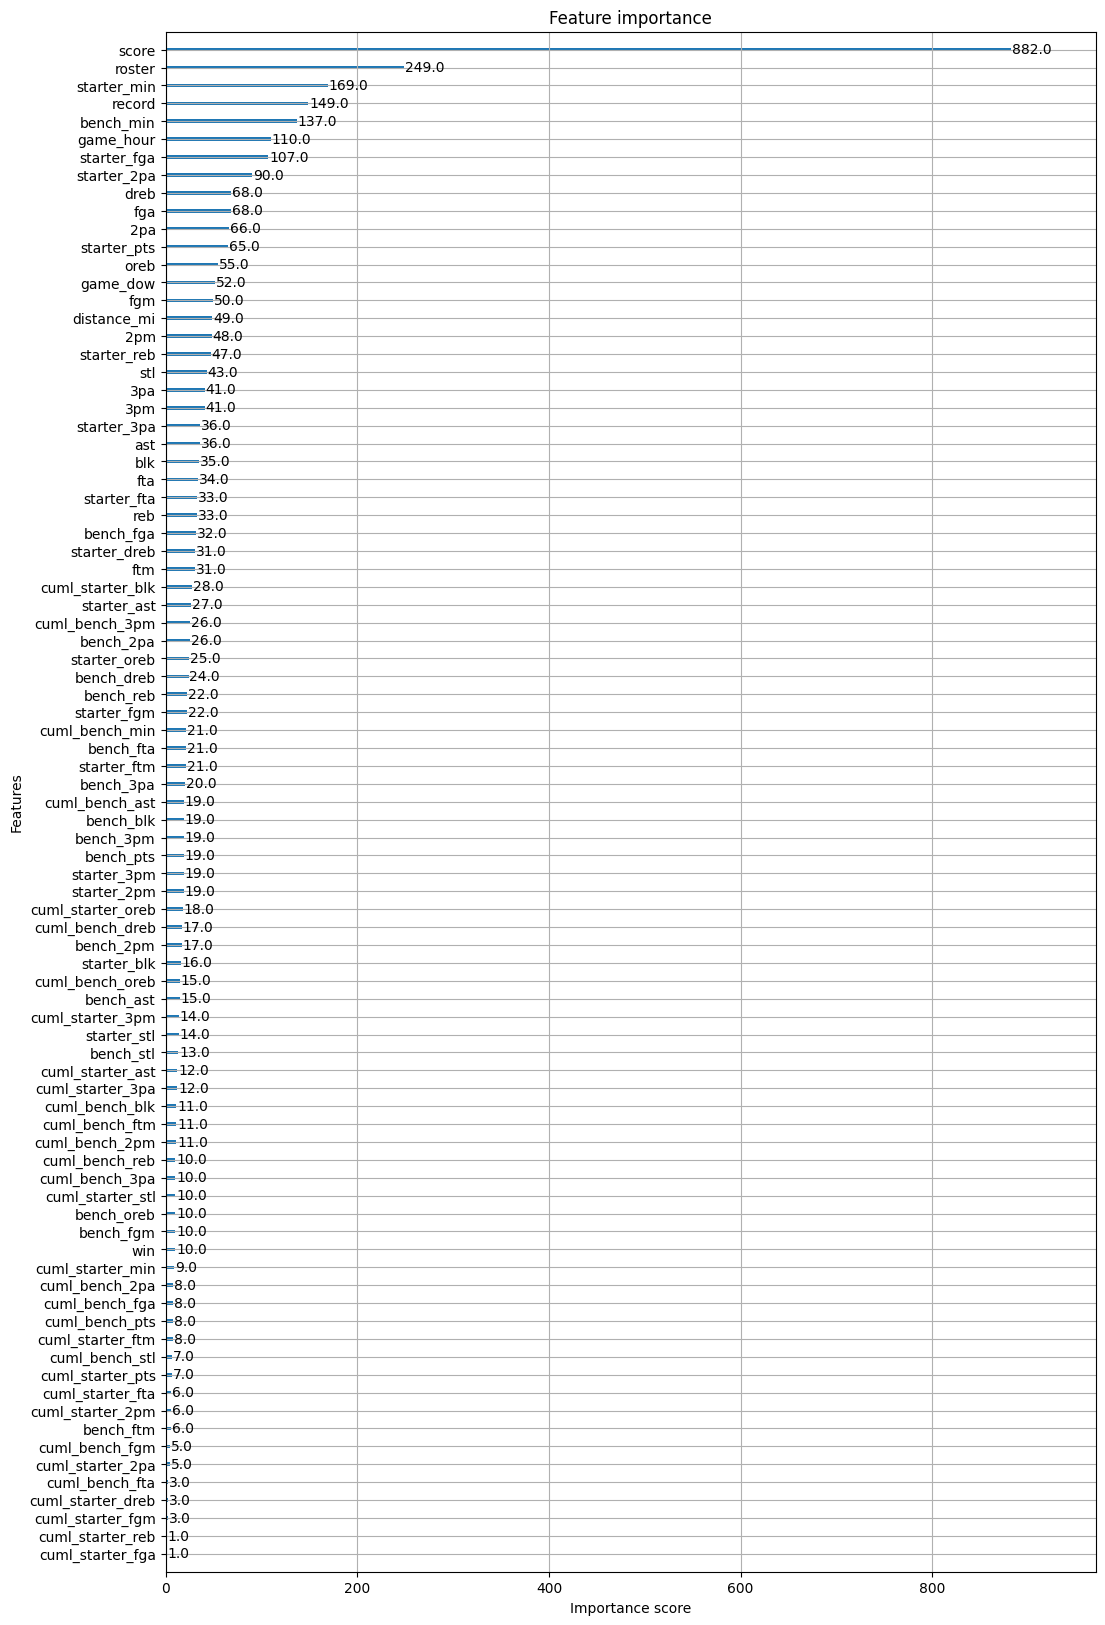

In [19]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,20))
plot_importance(model, max_num_features=int(train_x_df.shape[0]), ax=ax)
plt.show()

In [20]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
# evaluate model
scores = cross_val_score(model, train_x_df, train_y_df, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()))

Mean RMSE: 1.822 (0.324)


In [21]:
from sklearn.metrics import root_mean_squared_error

preds = model.predict(test_x)
rmse = root_mean_squared_error(test_y, preds)
print(f'Test RMSE: {rmse}')

Test RMSE: 2.0138141313953644


In [22]:
comparison_df = pd.DataFrame({'actual': test_y, 'predicted': preds})
comparison_df['diff'] = comparison_df['actual'] - comparison_df['predicted']
comparison_df

,actual,predicted,diff
56,134.0,106.962624,27.037376
117,87.0,86.993286,0.006714
40,69.0,69.015114,-0.015114
69,73.0,72.998756,0.001244
65,82.0,81.991539,0.008461
...,...,...,...
28,88.0,87.991882,0.008118
116,66.0,65.999870,0.000130
4,66.0,65.994751,0.005249
76,98.0,98.064972,-0.064972


In [23]:
comparison_df.describe()

,actual,predicted,diff
count,1057.000000,1057.000000,1057.000000
mean,73.028382,73.075531,-0.047150
std,11.781034,11.580298,2.014215
min,41.000000,40.430271,-27.704796
25%,65.000000,65.011971,-0.007103
50%,73.000000,72.998756,0.000320
75%,81.000000,81.001663,0.007195
max,134.000000,108.005394,27.037376


In [24]:
# Percent of valus outside of 2 stddev
outside_2std = len(comparison_df.loc[
    (comparison_df['diff'] > (2 * comparison_df['diff'].std()))
    | (comparison_df['diff'] < (2 * comparison_df['diff'].std()) * -1)])
pct = (outside_2std / len(test_y)) * 100
print(f'Percent of values outside of 2 stddev: {pct}%')

Percent of values outside of 2 stddev: 1.8921475875118259%


In [25]:
count_below_1pt = len(comparison_df.loc[(comparison_df['diff'] < 1) & (comparison_df['diff'] > -1)])
under1_pct = (count_below_1pt / len(test_y)) * 100
print(f'Percent of predictions under 1pt: {under1_pct}%')

Percent of predictions under 1pt: 96.40491958372753%


In [ ]:
model.save_model('mcbb_trained_20250728.model')

# Test on unseen data from the 2023 season

In [28]:
prefixes23 = [f'2023/{p}' for p in ['acc', 'americaeast', 'asun', 'atlantic10', 'big12', 'bigeast']]
info_23_df = load_data_files(prefixes23, '23', 'info')
info_23_df = clean_info_data(info_23_df)
info_23_df = xfm_info_data(info_23_df)
box_23_df = load_data_files(prefixes23, '23', 'box')

In [41]:
data_23_df = get_features(teams_df, info_23_df, box_23_df)

team: Abilene Christian Wildcats team_info: (1, 9) team len: 1
team: Air Force Falcons team_info: (2400, 0) team len: 2400
team: Akron Zips team_info: (1, 9) team len: 1
team: Alabama A&M Bulldogs team_info: (2, 9) team len: 2
team: Alabama Crimson Tide team_info: (5, 9) team len: 5
team: Alabama State Hornets team_info: (4, 9) team len: 4
team: Alcorn State Braves team_info: (1, 9) team len: 1
team: American University Eagles team_info: (5, 9) team len: 5
team: App State Mountaineers team_info: (3, 9) team len: 3
team: Arizona State Sun Devils team_info: (3, 9) team len: 3
team: Arizona Wildcats team_info: (1, 9) team len: 1
team: Arkansas Razorbacks team_info: (7, 9) team len: 7
team: Arkansas State Red Wolves team_info: (1, 9) team len: 1
team: Arkansas-Pine Bluff Golden Lions team_info: (3, 9) team len: 3
team: Army Black Knights team_info: (2, 9) team len: 2
team: Auburn Tigers team_info: (3, 9) team len: 3
team: Austin Peay Governors team_info: (47, 9) team len: 47
team: BYU Coug

In [58]:
data_23_df = data_23_df.drop_duplicates(subset=['game_id', 'team', 'game_day_dt'], keep='first')

In [56]:
preds_23 = model.predict(data_23_df.drop(['game_id', 'team', 'game_day_dt', 'target_score'], axis=1))

Looks like overfitting to the 2024 season:

In [57]:
root_mean_squared_error(data_23_df['target_score'], preds_23)

9.320693706021924